# Source Detection (photutils.detection)

Documentation at the following link:

https://photutils.readthedocs.io/en/stable/detection.html

# Detecting stars

Photutils includes two widely-used tools that are used to detect stars in an image, $\color{blue}{\text{DAOFIND}}$ and IRAF’s $\color{blue}{\text{starfind}}$.

$\color{blue}{\text{DAOStarFinder}}$ is a class that provides an implementation of the $\color{blue}{\text{DAOFIND}}$ algorithm (Stetson 1987, PASP 99, 191). 

$\color{blue}{\text{IRAFStarFinder}}$ is a class that implements IRAF’s $\color{blue}{\text{starfind}}$ algorithm.

Documentation for DAOStarFinder and IRAFStarFinder at the following link:

https://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html#photutils.DAOStarFinder

https://photutils.readthedocs.io/en/stable/api/photutils.IRAFStarFinder.html#photutils.IRAFStarFinder

Differences between the two algorithm:

$\color{blue}{\text{DAOStarFinder}}$ can use an elliptical Gaussian kernel.

$\color{blue}{\text{IRAFStarFinder}}$ calculates the objects' centroid, roundness, and sharpness using image moments. 

$\color{blue}{\text{DAOStarFinder}}$ finds the object centroid by fitting the marginal x and y 1D distributions of the Gaussian kernel to the marginal x and y distributions of the input (unconvolved) data image. $\color{blue}{\text{DAOStarFinder}}$ calculates the object roundness using two methods. The `roundlo` and `roundhi` bounds are applied to both measures of roundness. The first method (`roundness1`; called SROUND in $\color{blue}{\text{DAOFIND}}$) is based on the source symmetry and is the ratio of a measure of the object’s bilateral (2-fold) to four-fold symmetry. The second roundness statistic (`roundness2`; called GROUND in $\color{blue}{\text{DAOFIND}}$) measures the ratio of the difference in the height of the best fitting Gaussian function in x minus the best fitting Gaussian function in y, divided by the average of the best fitting Gaussian functions in x and y. A circular source will have a zero roundness. A source extended in x or y will have a negative or positive roundness, respectively.

Example of **input** parameters for $\color{blue}{\text{DAOStarFinder}}$:

- **`threshold`** : float
The absolute image value above which to select sources.

- **`fwhm`** : float
The full-width half-maximum (FWHM) of the major axis of the Gaussian kernel in units of pixels.

Optional:

- **`ratio`** : float, optional
The ratio of the minor to major axis standard deviations of the Gaussian kernel. **`ratio`** must be strictly positive and less than or equal to 1.0. The default is 1.0 (i.e., a circular Gaussian kernel).

- **`theta`** : float, optional
The position angle (in degrees) of the major axis of the Gaussian kernel measured counter-clockwise from the positive x axis.

- **`sigma_radius`** : float, optional
The truncation radius of the Gaussian kernel in units of sigma (standard deviation) [1 sigma = FWHM / (2.0*sqrt(2.0*log(2.0)))].

- **`sharplo`** : float, optional
The lower bound on sharpness for object detection.

- **`sharphi`** : float, optional
The upper bound on sharpness for object detection.

- **`roundlo`** : float, optional
The lower bound on roundness for object detection.

- **`roundhi`** : float, optional
The upper bound on roundness for object detection.

- **`sky`** : float, optional
The background sky level of the image. Setting **`sky`** affects only the output values of the object **`peak`**, **flux**, and **mag** values. The default is 0.0, which should be used to replicate the results from $\color{blue}{\text{DAOFIND}}$.

- **`exclude_border`** : bool, optional
Set to True to exclude sources found within half the size of the convolution kernel from the image borders. The default is False, which is the mode used by $\color{blue}{\text{DAOFIND}}$.

- **`brightest`** : int, None, optional
Number of brightest objects to keep after sorting the full object list. **`brightest`** is set to None, all objects will be selected.

- **`peakmax`** : float, None, optional
Maximum peak pixel value in an object. Only objects whose peak pixel values are strictly smaller than **`peakmax`** will be selected. This may be used to exclude saturated sources. By default, when **`peakmax`** is set to $\color{blue}{\text{None}}$, all objects will be selected.

Output is a table of found stars with the following parameters:

- **`id`**: unique object identification number.
- xcentroid, ycentroid: object centroid.
- **`sharpness`**: object sharpness.
- **`roundness1`**: object roundness based on symmetry.
- **`roundness2`**: object roundness based on marginal Gaussian fits.
- **`npix`**: the total number of pixels in the Gaussian kernel array.
- **`sky`**: the input sky parameter.
- **`peak`**: the peak, sky-subtracted, pixel value of the object.
- **`flux`**: the object flux calculated as the peak density in the convolved image divided by the detection threshold. This derivation matches that of $\color{blue}{\text{DAOFIND}}$ if sky is 0.0.
- **`mag`**: the object instrumental magnitude calculated as -2.5 * log10(flux). The derivation matches that of $\color{blue}{\text{DAOFIND}}$ if sky is 0.0.

If no stars are found then an empty table is returned.

# Example

Let’s load an image from the bundled datasets and select a subset of the image. We will estimate the background and background noise using sigma-clipped statistics:

**Note**: the following link give access to load a few example datasets:

https://photutils.readthedocs.io/en/stable/datasets.html

In [1]:
from astropy.stats import sigma_clipped_stats
from photutils import datasets

#load_star image load an optical image of stars 

hdu = datasets.load_star_image()
data = hdu.data[0:401, 0:401]    
mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
print((mean, median, std)) 

(3668.09661145823, 3649.0, 204.41388592022312)


Now we will subtract the background and use an instance of $\color{blue}{\text{DAOStarFinder}}$ to find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. Running this class on the data yields an astropy $\color{blue}{\text{Table}}$ containing the results of the star finder:

In [5]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)    
sources = daofind(data - median)    
for col in sources.colnames:    
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)

 id xcentroid ycentroid sharpness  ... sky peak    flux       mag     
--- --------- --------- ---------- ... --- ---- --------- ------------
  1 144.24757 6.3797904 0.58156257 ...   0 6903 5.6976747   -1.8892441
  2 208.66907 6.8205805 0.48348966 ...   0 7896 6.7186388   -2.0682032
  3 216.92614 6.5775933 0.69359525 ...   0 2195 1.6662764  -0.55436758
  4 351.62519 8.5459013 0.48577834 ...   0 6977 5.8970385   -1.9265849
  5 377.51991 12.065501 0.52038488 ...   0 1260 1.1178252  -0.12093477
  6 294.27284 12.737191 0.68021892 ...   0 2059 1.4809613  -0.42635928
  7 85.217728 14.710347 0.62394134 ...   0 1458 1.2457081  -0.23854075
  8 137.94129 17.464718 0.54340548 ...   0 5451 4.6833069   -1.6763815
  9 130.32797 18.678087 0.62723987 ...   0 3432 2.8641222   -1.1424789
 10  143.1105 18.623553 0.52124876 ...   0 6722 5.7556336   -1.9002329
...       ...       ...        ... ... ...  ...       ...          ...
276 292.58712 389.31304  0.3548582 ...   0 9231   4.64095   -1.6665172
277  9

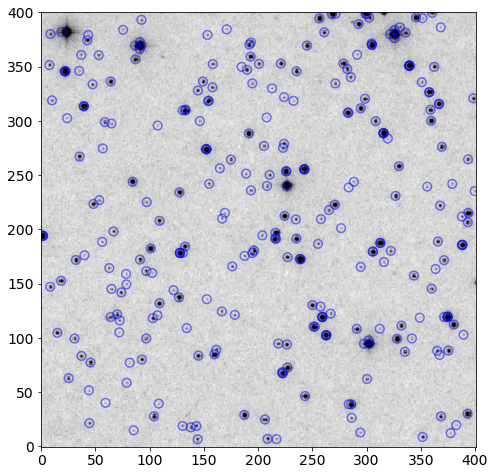

In [3]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import numpy as np

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

#plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

# Masking Region

Regions of the input image can be masked by using the **`mask`** keyword with the $\color{blue}{\text{DAOStarFinder}}$ or $\color{blue}{\text{IRAFStarFinder}}$ instance. This simple examples uses $\color{blue}{\text{DAOStarFinder}}$ and masks two rectangular regions. No sources will be detected in the masked regions:

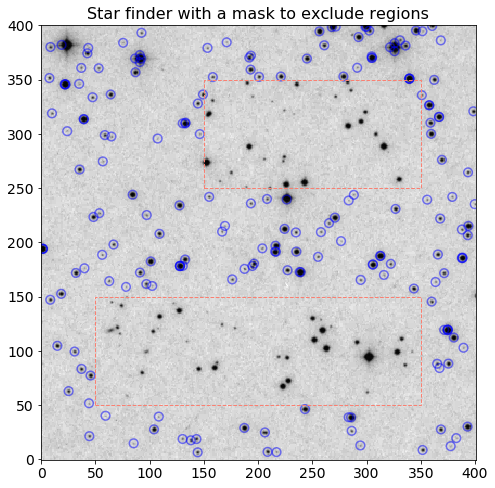

In [4]:
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import datasets, DAOStarFinder, CircularAperture
from photutils import RectangularAperture
plt.rcParams['figure.figsize'] = (14, 8)

hdu = datasets.load_star_image()
data = hdu.data[0:401, 0:401]
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
mask = np.zeros_like(data, dtype=bool)
mask[50:151, 50:351] = True
mask[250:351, 150:351] = True
sources = daofind(data - median, mask = mask)

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)

norm = ImageNormalize(stretch=SqrtStretch())

plt.imshow(data, cmap='Greys', origin='lower', norm=norm)
plt.title('Star finder with a mask to exclude regions')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

rect1 = RectangularAperture((200, 100), 300, 100, theta=0.)
rect2 = RectangularAperture((250, 300), 200, 100, theta=0.)

rect1.plot(color='salmon', ls='dashed')
rect2.plot(color='salmon', ls='dashed')

# Local Peak Detection

Photutils also includes a $\color{blue}{\text{find_peaks()}}$ function to find local peaks in an image that are above a specified threshold value. Peaks are the local maxima above a specified threshold that are separated by a specified minimum number of pixels.

Documentation at the following link:

https://photutils.readthedocs.io/en/stable/api/photutils.detection.find_peaks.html#photutils.detection.find_peaks

By default, the returned pixel coordinates are always integer-valued (i.e., no centroiding is performed, only the peak pixel is identified). However, a centroiding function can be input via the **`centroid_2dg`** keyword to $\color{blue}{\text{find_peaks()}}$ to compute centroid coordinates with subpixel precision.

**NB: This is particular important to select stars that can be used to build and empirical PSF model**

Let's find the local peaks in an image that are 10 sigma above the backgrounds and separated by at least 10 pixels:

In [59]:
hdu = datasets.load_star_image()
data = hdu.data[0:401, 0:401]   

from photutils import find_peaks
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
threshold = median + (10. * std)
tbl = find_peaks(data, threshold, box_size=11)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(tbl[:10])    # print only the first 10 peaks


x_peak y_peak peak_value
------ ------ ----------
   144      6      10552
   209      7      11545
   217      7       5844
   352      8      10626
   352      9      10626
   294     13       5708
   130     19       7081
   143     19      10371
    44     21       9043
   206     25      11272


Let's calculate also the centroid coordinates:

In [26]:
from photutils.centroids import centroid_2dg
hdu = datasets.load_star_image()
data = hdu.data[0:401, 0:401]
tbl = find_peaks(data, threshold, box_size=11, centroid_func=centroid_2dg)
tbl['peak_value'].info.format = '%.8g'  
print(tbl[:10])

x_peak y_peak peak_value     x_centroid         y_centroid    
------ ------ ---------- ------------------ ------------------
   144      6      10552   144.246199270693  6.347999665478966
   209      7      11545 208.68104217723769  6.842048517989561
   217      7       5844 216.99785419996783  6.626732432541885
   352      8      10626 351.64662701531824  8.483798283373055
   352      9      10626 351.64648941221645  8.483694251837008
    16     11       4778 14.811325383291317 15.226172869912364
   377     12       4909  377.4707035697999 12.100637936988463
   294     13       5708 294.00247319912137 12.752087849857867
    23     14       4823  41.78823917969524  20.40659627047408
    85     15       5107  85.23538159666228 14.675154335360663


(0, 400)

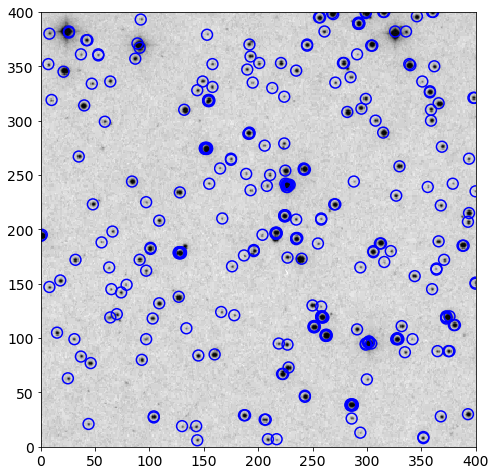

In [60]:
positions = (tbl['x_peak'], tbl['y_peak'])
apertures = CircularAperture(positions, r=5.)

plt.imshow(data, norm=norm, cmap='Greys')
apertures.plot(color='b', lw=1.5)
plt.xlim(0, data.shape[1]-1)
plt.ylim(0, data.shape[0]-1)

Using the function $\color{blue}{\text{make_source_mask}}$ we can select stars in a given magnitude/flux range:

In [63]:
from photutils import make_source_mask
mask = make_source_mask(data, snr=15, npixels=5, dilate_size=11)
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
threshold = median + (10. * std)
tbl = find_peaks(data, threshold, box_size=11, mask = mask)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(len(tbl))
print(tbl[:10]) # print only the first 10 peaks

66
x_peak y_peak peak_value
------ ------ ----------
   217      7       5844
   294     13       5708
   130     19       7081
    44     21       9043
   286     26       8635
   300     62       8465
   365     88       9684
   219     95       9582
    31     99       9625
    97     99       8139


(0, 400)

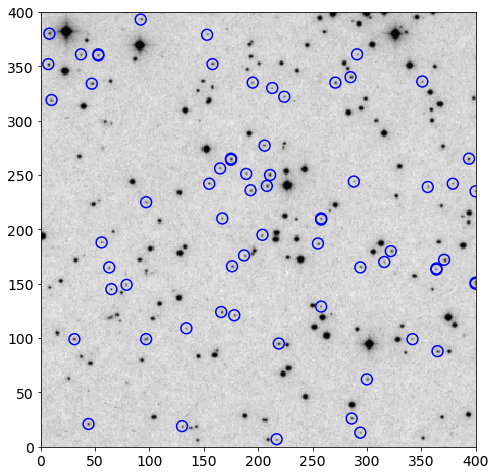

In [64]:
positions = (tbl['x_peak'], tbl['y_peak'])
apertures = CircularAperture(positions, r=5.)

plt.imshow(data, norm=norm, cmap='Greys')
apertures.plot(color='b', lw=1.5)
plt.xlim(0, data.shape[1]-1)
plt.ylim(0, data.shape[0]-1)